In [1]:
import os
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import lightning as L
import torch.utils.data as data
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'

In [2]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Sequential(nn.Linear(28 * 28, 64), nn.ReLU(), nn.Linear(64, 3))

    def forward(self, x):
        return self.l1(x)


class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Sequential(nn.Linear(3, 64), nn.ReLU(), nn.Linear(64, 28 * 28))

    def forward(self, x):
        return self.l1(x)
    
class LitAutoEncoder(L.LightningModule):
    def __init__(self, encoder, decoder, lr = 1e-3):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.lr = lr

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = F.mse_loss(x_hat, x)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        # this is the test loop
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        test_loss = F.mse_loss(x_hat, x)
        self.log("test_loss", test_loss, prog_bar=True)
        
    def validation_step(self, batch, batch_idx):
        # this is the validation loop
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        val_loss = F.mse_loss(x_hat, x)
        self.log("val_loss", val_loss, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

In [3]:
transform = transforms.ToTensor()
train_set = MNIST('./data/', download=True, train=True, transform=transform)
test_set = MNIST('./data/', download=True, train=False, transform=transform)

# use 20% of training data for validation
train_set_size = int(len(train_set) * 0.8)
valid_set_size = len(train_set) - train_set_size

# split the train set into two
seed = torch.Generator().manual_seed(42)
train_set, valid_set = data.random_split(train_set, [train_set_size, valid_set_size], generator=seed)

train_loader = DataLoader(train_set, batch_size=256, num_workers=9, persistent_workers=True)
valid_loader = DataLoader(valid_set, batch_size=512, num_workers=9, persistent_workers=True)
test_loader = DataLoader(test_set, batch_size=512, num_workers=9, persistent_workers=True)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=100` reached.
Finding best initial lr: 100%|██████████| 100/100 [00:00<00:00, 117.91it/s]
Learning rate set to 0.005754399373371567
Restoring states from the checkpoint path at /Users/yinnnyou/workspace/medical_imaging_imbalancing/.lr_find_246827bb-b03e-4780-8f41-377c33fb2c96.ckpt
Restored all states from the checkpoint at /Users/yinnnyou/workspace/medical_imaging_imbalancing/.lr_find_246827bb-b03e-4780-8f41-377c33fb2c96.ckpt
/var/folders/w8/pyvvstps3zz38md50zqcznhc0000gn/T/ipykernel_15654/1932752801.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()

  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 50.4 K
1 | decoder | Decoder | 51.2 K
------------------------------------
101 K     Trainable params
0         Non-traina

Epoch 93:  11%|█         | 21/188 [00:00<00:01, 102.15it/s, v_num=2, train_loss=0.0393, val_loss=0.0403] 

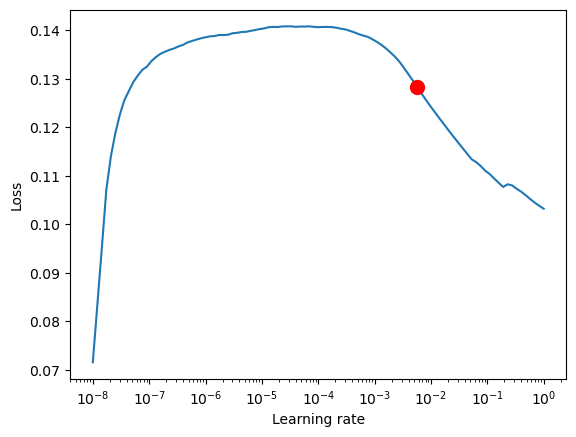

In [6]:
# model
from lightning.pytorch.tuner import Tuner

autoencoder = LitAutoEncoder(Encoder(), Decoder())

trainer = L.Trainer(max_epochs=300)
tuner = Tuner(trainer)
lr_finder = tuner.lr_find(autoencoder, attr_name="lr", 
              train_dataloaders=train_loader, val_dataloaders=valid_loader)

# train model
# trainer = L.Trainer(max_epochs=300)
# trainer.fit(model=autoencoder, 
#             train_dataloaders=train_loader, val_dataloaders=valid_loader)

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()
trainer.fit(autoencoder, train_dataloaders=train_loader, val_dataloaders=valid_loader)